In [1]:
# import resources
import numpy as np
import torch

# random seed (for reproducibility)
seed = 1
# set random seed for numpy
np.random.seed(seed)
# set random seed for pytorch
torch.manual_seed(seed)

In [2]:
from torchvision import datasets
import torchvision.transforms as transforms

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20

# convert data to Tensors
transform = transforms.ToTensor()

# choose the training and test datasets
train_data = datasets.MNIST(root='data', train=True,
                            download=False, transform=transform)

test_data = datasets.MNIST(root='data', train=False, 
                           download=False, transform=transform)

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, 
                                           batch_size=batch_size, 
                                           num_workers=num_workers)

test_loader = torch.utils.data.DataLoader(test_data, 
                                          batch_size=batch_size, 
                                          num_workers=num_workers)

/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  if sys.path[0] == '':


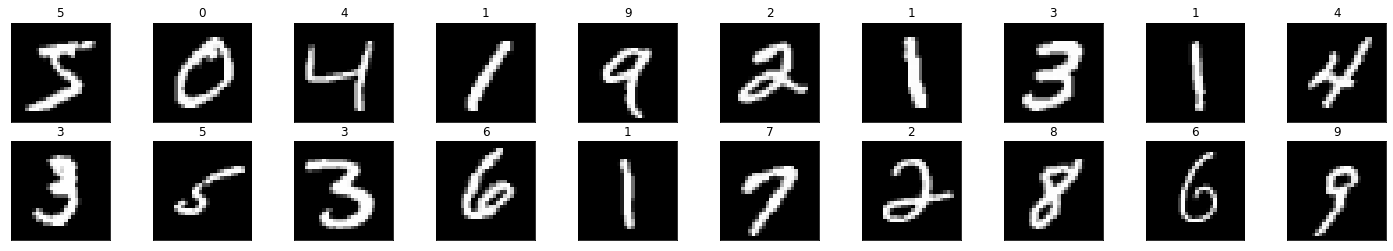

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
    
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(batch_size):
    ax = fig.add_subplot(2, batch_size/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    # print out the correct label for each image
    # .item() gets the value contained in a Tensor
    ax.set_title(str(labels[idx].item()))

In [8]:
# batchsize:20.  in_channel:1. 
images.shape, labels.shape

((20, 1, 28, 28), torch.Size([20]))

In [5]:
import torch.nn as nn
import torch.nn.functional as F

# Encoder

编码器由一系列层组成，负责将 28 x 28 MNIST 图像作为输入并学习将其编码为 16 维输出向量。

<img src='assets/capsule_encoder.png' width=70%/>

(Image from [the original Capsule Network paper](https://arxiv.org/pdf/1710.09829.pdf))

## First Layer: Convolutional Layer

我们编码器的第一层是卷积层，它将学习在给定的输入图像中提取特征，如边缘。 
> In the original paper, this first convolutional layer has a `depth=256`, and uses a `kernel_size=9`, `stride=1`, and `padding=0`. This also calls for a `ReLu` activation on the outputs.

因此，给定一个输入 MNIST 图像，这个卷积层将创建 256 个过滤图像的堆栈。

For a 28x28 input image, a 9x9 kernel will not be able to perfectly overlay on the edges pixels of an image and, without any padding, I'll actually lose a border of 4 pixels on *each* side of the image as I filter it. So, for an input of size `(batch_size, 28, 28, 1)`, I'll get an output, convolutional layer with the dimensions `(batch_size, 20, 20, 256)`. And `batch_size` is just the number of input images that are processed in a batch; defined above in the `DataLoader` as `20`.

In [6]:
class ConvLayer(nn.Module):
    
    def __init__(self, in_channels=1, out_channels=256):
        '''Constructs the ConvLayer with a specified input and output size.
           param in_channels: input depth of an image, default value = 1
           param out_channels: output depth of the convolutional layer, default value = 256
           '''
        super(ConvLayer, self).__init__()

        # defining a convolutional layer of the specified size
        self.conv = nn.Conv2d(in_channels, out_channels, 
                              kernel_size=9, stride=1, padding=0)

    def forward(self, x):
        '''Defines the feedforward behavior.
           param x: the input to the layer; an input image
           return: a relu-activated, convolutional layer
           '''
        # 将 ReLu 激活应用于 conv 层的输出
        features = F.relu(self.conv(x)) # will have dimensions (batch_size, 20, 20, 256)
        return features

In [26]:
cnn = ConvLayer()
for batch_i, (images, target) in enumerate(train_loader):
    output = cnn(images)

In [24]:
output.shape

torch.Size([20, 256, 20, 20])

## Second Layer: Primary Capsules

这一层由 8 个“初级”胶囊组成，之所以这样称呼，是因为它们是胶囊的第一层。 它们将先前定义的卷积层的输出作为输入并产生一组输出向量。 本质上，每个胶囊负责生成在前一个卷积层中检测到的特征的加权组合。

根据论文，要获得一个胶囊的输出：
>* 定义一个具有`depth=32`, `kernel_size=9`, `**stride=2**`, and `padding=0` 的卷积层，并将其应用于上一层的特征。
* 通过将卷积层应用于大小为`(batch_size, 20, 20, 256)`, I will get a `(batch_size, 6, 6, 32)` Tensor as output for each of the 8 capsules. 
* I'll **reshape** this into an output vector using `.view(batch_size, 32*6*6, 1)`, for each of our 8 capsules and then stack those vectors.对于我们的 8 个胶囊中的每一个，我将使用 `.view(batch_size, 32*6*6, 1)` 将其**重塑**成一个输出向量，然后堆叠这些向量。
* Finally, I'll **squash** all of these vector; this is a nonlinear normalization step that forces the magnitude of the vectors to be in the range 0-1. 这是一个非线性归一化步骤，强制向量的大小在 0-1 的范围内。

#### A note on calculating dimensions

You may be wondering how I got from 20x20 to 6x6.

Again, I'm creating a border of 4 pixels on each side with a kernel_size of 9. So, I'll go from an x-y size of 20 - 4 on *all* sides to a size of 12. Then, with a `stride=2`, I'm efectively downsampling the previous inputs by a factor of 2, so I go from an x-y size of 12, divided by 2, to get an x-y size of 6. And you can read more about these precise output dimension calculations [at this Stanford cs231n page](http://cs231n.github.io/convolutional-networks/#conv) in the section on **spatial arrangement**.

### Squashing

> The magnitude of an output, capsule vector is a value between 0 and 1 that indicates the probability that a visual part (eyes, nose, etc.) exists and has been detected in an image. 输出的大小，胶囊向量是一个介于 0 和 1 之间的值，表示视觉部分（眼睛、鼻子等）存在并在图像中被检测到的概率。

To get this probability value, I define a nonlinear function `squash` that calculates a certain capsule's normalized, vector output using the following equation. 为了获得这个概率值，我定义了一个非线性函数 `squash`，它使用以下等式计算某个胶囊的归一化向量输出。

$$ v_j = \frac{||\ s_j^2\ ||\ s_j }{1 + ||\ s_j^2\ ||\ s_j } $$

$v_j$ 是我要计算的值，胶囊 $j$ 的归一化向量输出。而 $s_j$ 是那个胶囊的总输入；来自层 * 下方 * 胶囊 $j$ 中的胶囊的所有输出向量的加权和。对于除主要胶囊层之外的所有层，您可以将加权输入视为较小的*部分*的数量，这些部分认为它们是更大整体的一部分。这个想法是，如果你在一层中检测到鼻子和眼睛，有一定的概率（向量的大小），这就是下一层存在更大脸的证据。

> `squash` 函数是单个胶囊的加权输入的非线性函数。 它确保 $v_j$ 的大小是一个介于 0 和 1 之间的值。

#### ModuleList

Below, I'm taking advantage of PyTorch's [nn.ModuleList](https://pytorch.org/docs/stable/nn.html#modulelist) container to create a list of convolutional layers that is as long as my number of passed in capsules, `num_capsules`.

In [7]:
class PrimaryCaps(nn.Module):
    
    def __init__(self, num_capsules=8, in_channels=256, out_channels=32):
        '''Constructs a list of convolutional layers to be used in 
           creating capsule output vectors.
           param num_capsules: number of capsules to create
           param in_channels: input depth of features, default value = 256
           param out_channels: output depth of the convolutional layers, default value = 32
           '''
        super(PrimaryCaps, self).__init__()

        # creating a list of convolutional layers for each capsule I want to create
        # all capsules have a conv layer with the same parameters
        # num_capsules = 8
        # [batch, 20, 20, 256]-->[batch, 20, 20, 32]*8
        # 将256个特征变成8个特征，即8个胶囊
        self.capsules = nn.ModuleList([
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, 
                      kernel_size=9, stride=2, padding=0)
            for _ in range(num_capsules)])
    
    def forward(self, x):
        '''Defines the feedforward behavior.
           param x: the input; features from a convolutional layer
           return: a set of normalized, capsule output vectors
           '''
        # get batch size of inputs
        batch_size = x.size(0)
        # reshape convolutional layer outputs to be (batch_size, vector_dim=1152, 1)
        # (batch_size, vector_dim=1152, 1)
        # 将每一个胶囊打平成一个矩阵，一共就有8个(batch, 1152, 1)
        u = [capsule(x).view(batch_size, 32 * 6 * 6, 1) for capsule in self.capsules]
        # 堆叠输出向量 u，每个胶囊一个
        u = torch.cat(u, dim=-1)
        # 压缩向量堆栈
        u_squash = self.squash(u)
        return u_squash
    
    # 将每个胶囊的输出限制在[0, 1]，即为眼睛或者鼻子的概率
    def squash(self, input_tensor):
        '''Squashes an input Tensor so it has a magnitude between 0-1.
           param input_tensor: a stack of capsule inputs, s_j
           return: a stack of normalized, capsule output vectors, v_j
           '''
        squared_norm = (input_tensor ** 2).sum(dim=-1, keepdim=True)
        scale = squared_norm / (1 + squared_norm) # normalization coeff
        output_tensor = scale * input_tensor / torch.sqrt(squared_norm)    
        return output_tensor

In [37]:
cnn = ConvLayer()
caps = PrimaryCaps()
for batch_i, (images, target) in enumerate(train_loader):
    input_cnn = cnn(images)
    output = caps(input_cnn)

In [38]:
output.shape

torch.Size([20, 1152, 8])

In [39]:
output

tensor([[[-6.6595e-03,  7.3326e-05,  6.2196e-03,  ...,  6.2345e-03,
           1.8514e-03, -6.4398e-03],
         [-1.1266e-03, -1.1589e-03,  2.3050e-02,  ...,  1.4733e-03,
           1.3859e-02, -2.1660e-02],
         [ 9.9692e-03,  3.8479e-03,  1.8208e-02,  ...,  2.5100e-03,
           2.0906e-02, -1.4778e-02],
         ...,
         [-4.8182e-02,  1.0789e-02, -4.4792e-02,  ..., -8.0614e-03,
          -3.2481e-02, -7.0459e-02],
         [-2.3416e-03,  9.7683e-03, -2.0766e-02,  ...,  1.0676e-02,
          -2.6033e-02, -5.4141e-02],
         [ 3.6027e-03,  9.8313e-03, -1.1749e-02,  ..., -3.8473e-03,
          -4.5172e-03, -1.8807e-02]],

        [[-7.6130e-03, -8.8172e-03,  8.7977e-03,  ...,  2.5823e-03,
           2.3178e-03, -5.4273e-04],
         [ 5.1052e-04, -2.3620e-04, -1.0907e-03,  ...,  1.4184e-03,
           1.7482e-02, -1.2015e-02],
         [-5.3313e-03,  1.3814e-02, -5.0591e-03,  ..., -4.9688e-03,
           3.2524e-02,  6.9910e-03],
         ...,
         [-1.3933e-02,  5

## Third Layer: Digit Capsules

这一层由 10 个“数字”胶囊组成，每个数字类别 0-9。 每个胶囊将上面的 8 个主要胶囊产生的一批 1152 维向量作为输入。

> 这是网络编码器部分的最后一层，这 10 个胶囊中的每一个都负责产生一个 16 维的输出向量。

换句话说，该层从 1152 维的输入向量空间映射到 16 维的输出向量空间。 这也是您将看到 **动态路由** 实现的地方。

[batch, 1152, 8, 1]：每个胶囊的纬度是[1152, 1]，一共有8个胶囊
将每个胶囊乘权重矩阵

## Dynamic Routing

动态路由是在一层胶囊的输出和下一层胶囊的输入之间寻找*最佳*连接的过程。 它允许胶囊相互通信并确定数据如何通过它们！
> 无论胶囊网络看到什么样的输入图像，动态路由都可以确保“PrimaryCaps”层中的 *child* 胶囊的输出将被发送到这个“DigitCaps”层中最相关的 *parent* 胶囊。

### Coupling Coefficients

当胶囊网络初始化时，主胶囊不确定它们的输出应该去哪个父胶囊（数字胶囊）。 事实上，每个主胶囊都以一个**可能的父母**列表开始，这些**可能是下一层中的*所有*父胶囊。

> 这种可能的关系由一个叫做**耦合系数**的值表示，**c**，这是某个胶囊的输出应该去下一层的父胶囊的概率。

耦合系数的示例，写在子节点与其可能的父节点之间的连接线上，如下图所示。 具有两个可能的父节点的子节点开始时两者的耦合系数相同：0.5。

<img src='assets/coupling_coeff.png' width=30%/>

(Image from [my blog post on Capsule Nets](https://cezannec.github.io/Capsule_Networks/))

所有可能的父母的耦合系数可以被描绘成一个离散的概率分布。 在一个子胶囊和所有可能的父胶囊之间的所有连接中，耦合系数之和应为 1。


### Routing by Agreement

动态路由是更新这些耦合系数的迭代过程。 胶囊 $i$ 与其上层所有胶囊 $j$ 之间的耦合系数 $c_{ij}$ 总和为 1，并由路由 **softmax** 函数确定，其初始对数为 $b_{ij}$ 是胶囊 $i$ *应该* 耦合到胶囊 $j$ 的对数先验概率。 $b_{ij}$ 与主胶囊（长度为 1152）和数字胶囊（10）的输出向量之间可能存在的联系一样多。

$$c_{ij} = \frac{e^{\ b_{ij}}}{\sum_{k}\ {e^{\ b_{ik}}}} $$

在网络训练期间执行的更新过程对于单个胶囊如下：

> 1. 每个子胶囊都会输出一些向量 $u$，其大小表示部件的*存在*，其方向表示部件的广义姿态。
2. 对于每个可能的父级，子胶囊计算一个预测向量 $\hat{u}$，它是其输出向量 $u$ 乘以权重矩阵 $W$ 的函数。 $W$ 代表空间中的线性变换——就像一些旋转和平移——$\hat{u}$ 可以被认为是对父胶囊输出向量的位置和方向的预测。
3. 如果预测向量 $\hat{u}$ 与父胶囊输出向量 $v$ 有一个很大的**点积**，那么这些向量被称为 **agree** 和耦合系数*那个*父母和子胶囊之间的增加，而该子胶囊和*所有其他*父母之间的耦合系数减小。
4. 父输出向量 $v$ 和预测向量 $\hat{u}$ 之间的点积被称为胶囊 **agreement** 的形式度量 $a$。
5. 此协议会影响信息在网络中移动时的加权方式。
6. 新的 $b_{ij}$ 计算为 *当前* $b_{ij}$ 加上 $a$。
7. 新的耦合系数 $c_{ij}$ 使用上述 softmax 公式和新的 $b_{ij}$ 计算。
$$\hat{u} = W u $$

$$a = v \cdot u $$

$$b_{ij} = b_{ij} + a $$



这有时被称为**自上而下的反馈**；来自后一层父胶囊输出的反馈。

**一个典型的训练过程可能包括*三次*一致性迭代，其中$b_{ij}$被更新（通过步骤1-7），总共3次以获得将用于计算的最终耦合系数最终输出，$v_j$.**

> 子胶囊和父胶囊之间的高耦合系数会增加子胶囊对父胶囊的贡献，从而*进一步*对齐它们的两个输出向量并使它们的一致性点积更大！这称为**路由协议**。

我应该注意到，与之前的 `PrimaryCaps` 层相比，这个计算改变了我计算数字胶囊 $s_j$ 总输入的方式。在`DigitCaps`的情况下，$s_j$是来自层*下面*的胶囊的所有输入向量的总和，$u$乘以权重矩阵$W$，换句话说$W u = \hat{u }$, *also* 乘以耦合系数。第一层胶囊只将卷积特征视为输入，这些特征没有为路由和使用耦合系数提供足够的信息。

$$ s_j = \sum{c_{ij} \ \hat{u}}$$

In [17]:
import helpers # to get transpose softmax function

# dynamic routing
def dynamic_routing(b_ij, u_hat, squash, routing_iterations=3):
    '''Performs dynamic routing between two capsule layers.
       param b_ij: initial log probabilities that capsule i should be coupled to capsule j
       param u_hat: input, weighted capsule vectors, W u
       param squash: given, normalizing squash function
       param routing_iterations: number of times to update coupling coefficients
       return: v_j, output capsule vectors
       '''    
    # update b_ij, c_ij for number of routing iterations
    for iteration in range(routing_iterations):
        # softmax calculation of coupling coefficients, c_ij
        # c_ij: torch.Size([10, 20, 1152, 1, 16])
        c_ij = helpers.softmax(b_ij, dim=2)

        # calculating total capsule inputs, s_j = sum(c_ij*u_hat)
        # s_j: torch.Size([10, 20, 1, 1, 16])
        s_j = (c_ij * u_hat).sum(dim=2, keepdim=True)

        # squashing to get a normalized vector output, v_j
        # v_j: torch.Size([10, 20, 1, 1, 16])
        v_j = squash(s_j)

        # if not on the last iteration, calculate agreement and new b_ij
        if iteration < routing_iterations - 1:
            # agreement
            a_ij = (u_hat * v_j).sum(dim=-1, keepdim=True)
            
            # new b_ij
            b_ij = b_ij + a_ij
    
    return v_j # return latest v_j

## Digit Capsules

Now that I've defined the dynamic routing process, I can complete the `DigitCaps` class.
* This layer is composed of 10 "digit" capsules, one for each of our digit classes 0-9. 
* Each capsule takes, as input, a batch of 1152-dimensional vectors produced by our 8 primary capsules, above. 
* Each of these 10 capsules is responsible for producing a **16-dimensional** output vector.

I suggest you train on GPU for a faster training time, and I'm checking for the availability of a GPU device, below.

In [18]:
class DigitCaps(nn.Module):
    
    def __init__(self, num_capsules=10, previous_layer_nodes=32*6*6, 
                 in_channels=8, out_channels=16):
        '''Constructs an initial weight matrix, W, and sets class variables.
           param num_capsules: number of capsules to create
           param previous_layer_nodes: dimension of input capsule vector, default value = 1152
           param in_channels: number of capsules in previous layer, default value = 8
           param out_channels: dimensions of output capsule vector, default value = 16
           '''
        super(DigitCaps, self).__init__()

        # setting class variables
        self.num_capsules = num_capsules
        self.previous_layer_nodes = previous_layer_nodes # vector input (dim=1152)
        self.in_channels = in_channels # previous layer's number of capsules

        # starting out with a randomly initialized weight matrix, W
        # these will be the weights connecting the PrimaryCaps and DigitCaps layers
        self.W = nn.Parameter(torch.randn(num_capsules, previous_layer_nodes, 
                                          in_channels, out_channels))

    def forward(self, u):
        '''Defines the feedforward behavior.
           param u: the input; vectors from the previous PrimaryCaps layer
           return: a set of normalized, capsule output vectors
           '''
        
        # adding batch_size dims and stacking all u vectors
        # u 为上一层的输出
        # u: torch.Size([1, 20, 1152, 1, 8])
        u = u[None, :, :, None, :]
        
        # 4D weight matrix
        # W: torch.Size([10, 1, 1152, 8, 16])
        W = self.W[:, None, :, :, :]
        
        # calculating u_hat = W*u
        # u_hat: torch.Size([10, 20, 1152, 1, 16])
        u_hat = torch.matmul(u, W)

        # getting the correct size of b_ij
        # setting them all to 0, initially
        # b_ij初始化都为0
        # b_ij: torch.Size([10, 20, 1152, 1, 16])
        b_ij = torch.zeros(*u_hat.size())
        
#         # moving b_ij to GPU, if available
#         if TRAIN_ON_GPU:
#             b_ij = b_ij.cuda()

        # update coupling coefficients and calculate v_j
        v_j = dynamic_routing(b_ij, u_hat, self.squash, routing_iterations=3)

        return v_j # return final vector outputs
    
    
    def squash(self, input_tensor):
        '''Squashes an input Tensor so it has a magnitude between 0-1.
           param input_tensor: a stack of capsule inputs, s_j
           return: a stack of normalized, capsule output vectors, v_j
           '''
        # same squash function as before
        squared_norm = (input_tensor ** 2).sum(dim=-1, keepdim=True)
        scale = squared_norm / (1 + squared_norm) # normalization coeff
        output_tensor = scale * input_tensor / torch.sqrt(squared_norm)    
        return output_tensor
    

In [16]:
cnn = ConvLayer()
caps = PrimaryCaps()
digitCaps = DigitCaps()
for batch_i, (images, target) in enumerate(train_loader):
    input_cnn = cnn(images)
    caps_output = caps(input_cnn)
    digitCaps_output = digitCaps(caps_output)

u: torch.Size([1, 20, 1152, 1, 8])
W: torch.Size([10, 1, 1152, 8, 16])
u_hat: torch.Size([10, 20, 1152, 1, 16])
b_ij: torch.Size([10, 20, 1152, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
u: torch.Size([1, 20, 1152, 1, 8])
W: torch.Size([10, 1, 1152, 8, 16])
u_hat: torch.Size([10, 20, 1152, 1, 16])
b_ij: torch.Size([10, 20, 1152, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
u: torch.Size([1, 20, 11

u: torch.Size([1, 20, 1152, 1, 8])
W: torch.Size([10, 1, 1152, 8, 16])
u_hat: torch.Size([10, 20, 1152, 1, 16])
b_ij: torch.Size([10, 20, 1152, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
u: torch.Size([1, 20, 1152, 1, 8])
W: torch.Size([10, 1, 1152, 8, 16])
u_hat: torch.Size([10, 20, 1152, 1, 16])
b_ij: torch.Size([10, 20, 1152, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
u: torch.Size([1, 20, 11

u: torch.Size([1, 20, 1152, 1, 8])
W: torch.Size([10, 1, 1152, 8, 16])
u_hat: torch.Size([10, 20, 1152, 1, 16])
b_ij: torch.Size([10, 20, 1152, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
u: torch.Size([1, 20, 1152, 1, 8])
W: torch.Size([10, 1, 1152, 8, 16])
u_hat: torch.Size([10, 20, 1152, 1, 16])
b_ij: torch.Size([10, 20, 1152, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
u: torch.Size([1, 20, 11

u: torch.Size([1, 20, 1152, 1, 8])
W: torch.Size([10, 1, 1152, 8, 16])
u_hat: torch.Size([10, 20, 1152, 1, 16])
b_ij: torch.Size([10, 20, 1152, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
u: torch.Size([1, 20, 1152, 1, 8])
W: torch.Size([10, 1, 1152, 8, 16])
u_hat: torch.Size([10, 20, 1152, 1, 16])
b_ij: torch.Size([10, 20, 1152, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
u: torch.Size([1, 20, 11

u_hat: torch.Size([10, 20, 1152, 1, 16])
b_ij: torch.Size([10, 20, 1152, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
u: torch.Size([1, 20, 1152, 1, 8])
W: torch.Size([10, 1, 1152, 8, 16])
u_hat: torch.Size([10, 20, 1152, 1, 16])
b_ij: torch.Size([10, 20, 1152, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
u: torch.Size([1, 20, 1152, 1, 8])
W: torch.Size([10, 1, 1152, 8, 16])
u_hat: torch.Size([10, 2

u: torch.Size([1, 20, 1152, 1, 8])
W: torch.Size([10, 1, 1152, 8, 16])
u_hat: torch.Size([10, 20, 1152, 1, 16])
b_ij: torch.Size([10, 20, 1152, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
u: torch.Size([1, 20, 1152, 1, 8])
W: torch.Size([10, 1, 1152, 8, 16])
u_hat: torch.Size([10, 20, 1152, 1, 16])
b_ij: torch.Size([10, 20, 1152, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
u: torch.Size([1, 20, 11

u: torch.Size([1, 20, 1152, 1, 8])
W: torch.Size([10, 1, 1152, 8, 16])
u_hat: torch.Size([10, 20, 1152, 1, 16])
b_ij: torch.Size([10, 20, 1152, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
u: torch.Size([1, 20, 1152, 1, 8])
W: torch.Size([10, 1, 1152, 8, 16])
u_hat: torch.Size([10, 20, 1152, 1, 16])
b_ij: torch.Size([10, 20, 1152, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
u: torch.Size([1, 20, 11

u: torch.Size([1, 20, 1152, 1, 8])
W: torch.Size([10, 1, 1152, 8, 16])
u_hat: torch.Size([10, 20, 1152, 1, 16])
b_ij: torch.Size([10, 20, 1152, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
u: torch.Size([1, 20, 1152, 1, 8])
W: torch.Size([10, 1, 1152, 8, 16])
u_hat: torch.Size([10, 20, 1152, 1, 16])
b_ij: torch.Size([10, 20, 1152, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
u: torch.Size([1, 20, 11

u: torch.Size([1, 20, 1152, 1, 8])
W: torch.Size([10, 1, 1152, 8, 16])
u_hat: torch.Size([10, 20, 1152, 1, 16])
b_ij: torch.Size([10, 20, 1152, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
u: torch.Size([1, 20, 1152, 1, 8])
W: torch.Size([10, 1, 1152, 8, 16])
u_hat: torch.Size([10, 20, 1152, 1, 16])
b_ij: torch.Size([10, 20, 1152, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
u: torch.Size([1, 20, 11

u: torch.Size([1, 20, 1152, 1, 8])
W: torch.Size([10, 1, 1152, 8, 16])
u_hat: torch.Size([10, 20, 1152, 1, 16])
b_ij: torch.Size([10, 20, 1152, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
u: torch.Size([1, 20, 1152, 1, 8])
W: torch.Size([10, 1, 1152, 8, 16])
u_hat: torch.Size([10, 20, 1152, 1, 16])
b_ij: torch.Size([10, 20, 1152, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
u: torch.Size([1, 20, 11

u: torch.Size([1, 20, 1152, 1, 8])
W: torch.Size([10, 1, 1152, 8, 16])
u_hat: torch.Size([10, 20, 1152, 1, 16])
b_ij: torch.Size([10, 20, 1152, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
u: torch.Size([1, 20, 1152, 1, 8])
W: torch.Size([10, 1, 1152, 8, 16])
u_hat: torch.Size([10, 20, 1152, 1, 16])
b_ij: torch.Size([10, 20, 1152, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
u: torch.Size([1, 20, 11

u: torch.Size([1, 20, 1152, 1, 8])
W: torch.Size([10, 1, 1152, 8, 16])
u_hat: torch.Size([10, 20, 1152, 1, 16])
b_ij: torch.Size([10, 20, 1152, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
u: torch.Size([1, 20, 1152, 1, 8])
W: torch.Size([10, 1, 1152, 8, 16])
u_hat: torch.Size([10, 20, 1152, 1, 16])
b_ij: torch.Size([10, 20, 1152, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
u: torch.Size([1, 20, 11

u: torch.Size([1, 20, 1152, 1, 8])
W: torch.Size([10, 1, 1152, 8, 16])
u_hat: torch.Size([10, 20, 1152, 1, 16])
b_ij: torch.Size([10, 20, 1152, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
u: torch.Size([1, 20, 1152, 1, 8])
W: torch.Size([10, 1, 1152, 8, 16])
u_hat: torch.Size([10, 20, 1152, 1, 16])
b_ij: torch.Size([10, 20, 1152, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
u: torch.Size([1, 20, 11

u: torch.Size([1, 20, 1152, 1, 8])
W: torch.Size([10, 1, 1152, 8, 16])
u_hat: torch.Size([10, 20, 1152, 1, 16])
b_ij: torch.Size([10, 20, 1152, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
u: torch.Size([1, 20, 1152, 1, 8])
W: torch.Size([10, 1, 1152, 8, 16])
u_hat: torch.Size([10, 20, 1152, 1, 16])
b_ij: torch.Size([10, 20, 1152, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
u: torch.Size([1, 20, 11

u: torch.Size([1, 20, 1152, 1, 8])
W: torch.Size([10, 1, 1152, 8, 16])
u_hat: torch.Size([10, 20, 1152, 1, 16])
b_ij: torch.Size([10, 20, 1152, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
u: torch.Size([1, 20, 1152, 1, 8])
W: torch.Size([10, 1, 1152, 8, 16])
u_hat: torch.Size([10, 20, 1152, 1, 16])
b_ij: torch.Size([10, 20, 1152, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
u: torch.Size([1, 20, 11

u: torch.Size([1, 20, 1152, 1, 8])
W: torch.Size([10, 1, 1152, 8, 16])
u_hat: torch.Size([10, 20, 1152, 1, 16])
b_ij: torch.Size([10, 20, 1152, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
u: torch.Size([1, 20, 1152, 1, 8])
W: torch.Size([10, 1, 1152, 8, 16])
u_hat: torch.Size([10, 20, 1152, 1, 16])
b_ij: torch.Size([10, 20, 1152, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
u: torch.Size([1, 20, 11

u: torch.Size([1, 20, 1152, 1, 8])
W: torch.Size([10, 1, 1152, 8, 16])
u_hat: torch.Size([10, 20, 1152, 1, 16])
b_ij: torch.Size([10, 20, 1152, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
u: torch.Size([1, 20, 1152, 1, 8])
W: torch.Size([10, 1, 1152, 8, 16])
u_hat: torch.Size([10, 20, 1152, 1, 16])
b_ij: torch.Size([10, 20, 1152, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
u: torch.Size([1, 20, 11

u: torch.Size([1, 20, 1152, 1, 8])
W: torch.Size([10, 1, 1152, 8, 16])
u_hat: torch.Size([10, 20, 1152, 1, 16])
b_ij: torch.Size([10, 20, 1152, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
u: torch.Size([1, 20, 1152, 1, 8])
W: torch.Size([10, 1, 1152, 8, 16])
u_hat: torch.Size([10, 20, 1152, 1, 16])
b_ij: torch.Size([10, 20, 1152, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
u: torch.Size([1, 20, 11

u: torch.Size([1, 20, 1152, 1, 8])
W: torch.Size([10, 1, 1152, 8, 16])
u_hat: torch.Size([10, 20, 1152, 1, 16])
b_ij: torch.Size([10, 20, 1152, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
u: torch.Size([1, 20, 1152, 1, 8])
W: torch.Size([10, 1, 1152, 8, 16])
u_hat: torch.Size([10, 20, 1152, 1, 16])
b_ij: torch.Size([10, 20, 1152, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
u: torch.Size([1, 20, 11

u: torch.Size([1, 20, 1152, 1, 8])
W: torch.Size([10, 1, 1152, 8, 16])
u_hat: torch.Size([10, 20, 1152, 1, 16])
b_ij: torch.Size([10, 20, 1152, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
u: torch.Size([1, 20, 1152, 1, 8])
W: torch.Size([10, 1, 1152, 8, 16])
u_hat: torch.Size([10, 20, 1152, 1, 16])
b_ij: torch.Size([10, 20, 1152, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
u: torch.Size([1, 20, 11

u: torch.Size([1, 20, 1152, 1, 8])
W: torch.Size([10, 1, 1152, 8, 16])
u_hat: torch.Size([10, 20, 1152, 1, 16])
b_ij: torch.Size([10, 20, 1152, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
u: torch.Size([1, 20, 1152, 1, 8])
W: torch.Size([10, 1, 1152, 8, 16])
u_hat: torch.Size([10, 20, 1152, 1, 16])
b_ij: torch.Size([10, 20, 1152, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
u: torch.Size([1, 20, 11

u: torch.Size([1, 20, 1152, 1, 8])
W: torch.Size([10, 1, 1152, 8, 16])
u_hat: torch.Size([10, 20, 1152, 1, 16])
b_ij: torch.Size([10, 20, 1152, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
u: torch.Size([1, 20, 1152, 1, 8])
W: torch.Size([10, 1, 1152, 8, 16])
u_hat: torch.Size([10, 20, 1152, 1, 16])
b_ij: torch.Size([10, 20, 1152, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
u: torch.Size([1, 20, 11

u: torch.Size([1, 20, 1152, 1, 8])
W: torch.Size([10, 1, 1152, 8, 16])
u_hat: torch.Size([10, 20, 1152, 1, 16])
b_ij: torch.Size([10, 20, 1152, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
u: torch.Size([1, 20, 1152, 1, 8])
W: torch.Size([10, 1, 1152, 8, 16])
u_hat: torch.Size([10, 20, 1152, 1, 16])
b_ij: torch.Size([10, 20, 1152, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
u: torch.Size([1, 20, 11

u: torch.Size([1, 20, 1152, 1, 8])
W: torch.Size([10, 1, 1152, 8, 16])
u_hat: torch.Size([10, 20, 1152, 1, 16])
b_ij: torch.Size([10, 20, 1152, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
u: torch.Size([1, 20, 1152, 1, 8])
W: torch.Size([10, 1, 1152, 8, 16])
u_hat: torch.Size([10, 20, 1152, 1, 16])
b_ij: torch.Size([10, 20, 1152, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
u: torch.Size([1, 20, 11

u: torch.Size([1, 20, 1152, 1, 8])
W: torch.Size([10, 1, 1152, 8, 16])
u_hat: torch.Size([10, 20, 1152, 1, 16])
b_ij: torch.Size([10, 20, 1152, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
u: torch.Size([1, 20, 1152, 1, 8])
W: torch.Size([10, 1, 1152, 8, 16])
u_hat: torch.Size([10, 20, 1152, 1, 16])
b_ij: torch.Size([10, 20, 1152, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
u: torch.Size([1, 20, 11

u: torch.Size([1, 20, 1152, 1, 8])
W: torch.Size([10, 1, 1152, 8, 16])
u_hat: torch.Size([10, 20, 1152, 1, 16])
b_ij: torch.Size([10, 20, 1152, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
u: torch.Size([1, 20, 1152, 1, 8])
W: torch.Size([10, 1, 1152, 8, 16])
u_hat: torch.Size([10, 20, 1152, 1, 16])
b_ij: torch.Size([10, 20, 1152, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
u: torch.Size([1, 20, 11

u: torch.Size([1, 20, 1152, 1, 8])
W: torch.Size([10, 1, 1152, 8, 16])
u_hat: torch.Size([10, 20, 1152, 1, 16])
b_ij: torch.Size([10, 20, 1152, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
u: torch.Size([1, 20, 1152, 1, 8])
W: torch.Size([10, 1, 1152, 8, 16])
u_hat: torch.Size([10, 20, 1152, 1, 16])
b_ij: torch.Size([10, 20, 1152, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
u: torch.Size([1, 20, 11

u: torch.Size([1, 20, 1152, 1, 8])
W: torch.Size([10, 1, 1152, 8, 16])
u_hat: torch.Size([10, 20, 1152, 1, 16])
b_ij: torch.Size([10, 20, 1152, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
u: torch.Size([1, 20, 1152, 1, 8])
W: torch.Size([10, 1, 1152, 8, 16])
u_hat: torch.Size([10, 20, 1152, 1, 16])
b_ij: torch.Size([10, 20, 1152, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
u: torch.Size([1, 20, 11

u: torch.Size([1, 20, 1152, 1, 8])
W: torch.Size([10, 1, 1152, 8, 16])
u_hat: torch.Size([10, 20, 1152, 1, 16])
b_ij: torch.Size([10, 20, 1152, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
u: torch.Size([1, 20, 1152, 1, 8])
W: torch.Size([10, 1, 1152, 8, 16])
u_hat: torch.Size([10, 20, 1152, 1, 16])
b_ij: torch.Size([10, 20, 1152, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
u: torch.Size([1, 20, 11

u: torch.Size([1, 20, 1152, 1, 8])
W: torch.Size([10, 1, 1152, 8, 16])
u_hat: torch.Size([10, 20, 1152, 1, 16])
b_ij: torch.Size([10, 20, 1152, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
u: torch.Size([1, 20, 1152, 1, 8])
W: torch.Size([10, 1, 1152, 8, 16])
u_hat: torch.Size([10, 20, 1152, 1, 16])
b_ij: torch.Size([10, 20, 1152, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
u: torch.Size([1, 20, 11

u: torch.Size([1, 20, 1152, 1, 8])
W: torch.Size([10, 1, 1152, 8, 16])
u_hat: torch.Size([10, 20, 1152, 1, 16])
b_ij: torch.Size([10, 20, 1152, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
u: torch.Size([1, 20, 1152, 1, 8])
W: torch.Size([10, 1, 1152, 8, 16])
u_hat: torch.Size([10, 20, 1152, 1, 16])
b_ij: torch.Size([10, 20, 1152, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
u: torch.Size([1, 20, 11

u: torch.Size([1, 20, 1152, 1, 8])
W: torch.Size([10, 1, 1152, 8, 16])
u_hat: torch.Size([10, 20, 1152, 1, 16])
b_ij: torch.Size([10, 20, 1152, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
u: torch.Size([1, 20, 1152, 1, 8])
W: torch.Size([10, 1, 1152, 8, 16])
u_hat: torch.Size([10, 20, 1152, 1, 16])
b_ij: torch.Size([10, 20, 1152, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
u: torch.Size([1, 20, 11

u_hat: torch.Size([10, 20, 1152, 1, 16])
b_ij: torch.Size([10, 20, 1152, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
u: torch.Size([1, 20, 1152, 1, 8])
W: torch.Size([10, 1, 1152, 8, 16])
u_hat: torch.Size([10, 20, 1152, 1, 16])
b_ij: torch.Size([10, 20, 1152, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
u: torch.Size([1, 20, 1152, 1, 8])
W: torch.Size([10, 1, 1152, 8, 16])
u_hat: torch.Size([10, 2

u: torch.Size([1, 20, 1152, 1, 8])
W: torch.Size([10, 1, 1152, 8, 16])
u_hat: torch.Size([10, 20, 1152, 1, 16])
b_ij: torch.Size([10, 20, 1152, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
u: torch.Size([1, 20, 1152, 1, 8])
W: torch.Size([10, 1, 1152, 8, 16])
u_hat: torch.Size([10, 20, 1152, 1, 16])
b_ij: torch.Size([10, 20, 1152, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
u: torch.Size([1, 20, 11

u: torch.Size([1, 20, 1152, 1, 8])
W: torch.Size([10, 1, 1152, 8, 16])
u_hat: torch.Size([10, 20, 1152, 1, 16])
b_ij: torch.Size([10, 20, 1152, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
u: torch.Size([1, 20, 1152, 1, 8])
W: torch.Size([10, 1, 1152, 8, 16])
u_hat: torch.Size([10, 20, 1152, 1, 16])
b_ij: torch.Size([10, 20, 1152, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
u: torch.Size([1, 20, 11

u: torch.Size([1, 20, 1152, 1, 8])
W: torch.Size([10, 1, 1152, 8, 16])
u_hat: torch.Size([10, 20, 1152, 1, 16])
b_ij: torch.Size([10, 20, 1152, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
u: torch.Size([1, 20, 1152, 1, 8])
W: torch.Size([10, 1, 1152, 8, 16])
u_hat: torch.Size([10, 20, 1152, 1, 16])
b_ij: torch.Size([10, 20, 1152, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
u: torch.Size([1, 20, 11

u: torch.Size([1, 20, 1152, 1, 8])
W: torch.Size([10, 1, 1152, 8, 16])
u_hat: torch.Size([10, 20, 1152, 1, 16])
b_ij: torch.Size([10, 20, 1152, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
u: torch.Size([1, 20, 1152, 1, 8])
W: torch.Size([10, 1, 1152, 8, 16])
u_hat: torch.Size([10, 20, 1152, 1, 16])
b_ij: torch.Size([10, 20, 1152, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
u: torch.Size([1, 20, 11

u: torch.Size([1, 20, 1152, 1, 8])
W: torch.Size([10, 1, 1152, 8, 16])
u_hat: torch.Size([10, 20, 1152, 1, 16])
b_ij: torch.Size([10, 20, 1152, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
u: torch.Size([1, 20, 1152, 1, 8])
W: torch.Size([10, 1, 1152, 8, 16])
u_hat: torch.Size([10, 20, 1152, 1, 16])
b_ij: torch.Size([10, 20, 1152, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
u: torch.Size([1, 20, 11

u: torch.Size([1, 20, 1152, 1, 8])
W: torch.Size([10, 1, 1152, 8, 16])
u_hat: torch.Size([10, 20, 1152, 1, 16])
b_ij: torch.Size([10, 20, 1152, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
u: torch.Size([1, 20, 1152, 1, 8])
W: torch.Size([10, 1, 1152, 8, 16])
u_hat: torch.Size([10, 20, 1152, 1, 16])
b_ij: torch.Size([10, 20, 1152, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
u: torch.Size([1, 20, 11

u: torch.Size([1, 20, 1152, 1, 8])
W: torch.Size([10, 1, 1152, 8, 16])
u_hat: torch.Size([10, 20, 1152, 1, 16])
b_ij: torch.Size([10, 20, 1152, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
u: torch.Size([1, 20, 1152, 1, 8])
W: torch.Size([10, 1, 1152, 8, 16])
u_hat: torch.Size([10, 20, 1152, 1, 16])
b_ij: torch.Size([10, 20, 1152, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
u: torch.Size([1, 20, 11

u_hat: torch.Size([10, 20, 1152, 1, 16])
b_ij: torch.Size([10, 20, 1152, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
u: torch.Size([1, 20, 1152, 1, 8])
W: torch.Size([10, 1, 1152, 8, 16])
u_hat: torch.Size([10, 20, 1152, 1, 16])
b_ij: torch.Size([10, 20, 1152, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
u: torch.Size([1, 20, 1152, 1, 8])
W: torch.Size([10, 1, 1152, 8, 16])
u_hat: torch.Size([10, 2

u: torch.Size([1, 20, 1152, 1, 8])
W: torch.Size([10, 1, 1152, 8, 16])
u_hat: torch.Size([10, 20, 1152, 1, 16])
b_ij: torch.Size([10, 20, 1152, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
u: torch.Size([1, 20, 1152, 1, 8])
W: torch.Size([10, 1, 1152, 8, 16])
u_hat: torch.Size([10, 20, 1152, 1, 16])
b_ij: torch.Size([10, 20, 1152, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
u: torch.Size([1, 20, 11

u_hat: torch.Size([10, 20, 1152, 1, 16])
b_ij: torch.Size([10, 20, 1152, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
u: torch.Size([1, 20, 1152, 1, 8])
W: torch.Size([10, 1, 1152, 8, 16])
u_hat: torch.Size([10, 20, 1152, 1, 16])
b_ij: torch.Size([10, 20, 1152, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
u: torch.Size([1, 20, 1152, 1, 8])
W: torch.Size([10, 1, 1152, 8, 16])
u_hat: torch.Size([10, 2

u: torch.Size([1, 20, 1152, 1, 8])
W: torch.Size([10, 1, 1152, 8, 16])
u_hat: torch.Size([10, 20, 1152, 1, 16])
b_ij: torch.Size([10, 20, 1152, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
u: torch.Size([1, 20, 1152, 1, 8])
W: torch.Size([10, 1, 1152, 8, 16])
u_hat: torch.Size([10, 20, 1152, 1, 16])
b_ij: torch.Size([10, 20, 1152, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
u: torch.Size([1, 20, 11

u: torch.Size([1, 20, 1152, 1, 8])
W: torch.Size([10, 1, 1152, 8, 16])
u_hat: torch.Size([10, 20, 1152, 1, 16])
b_ij: torch.Size([10, 20, 1152, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
u: torch.Size([1, 20, 1152, 1, 8])
W: torch.Size([10, 1, 1152, 8, 16])
u_hat: torch.Size([10, 20, 1152, 1, 16])
b_ij: torch.Size([10, 20, 1152, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
u: torch.Size([1, 20, 11

u_hat: torch.Size([10, 20, 1152, 1, 16])
b_ij: torch.Size([10, 20, 1152, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
u: torch.Size([1, 20, 1152, 1, 8])
W: torch.Size([10, 1, 1152, 8, 16])
u_hat: torch.Size([10, 20, 1152, 1, 16])
b_ij: torch.Size([10, 20, 1152, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
u: torch.Size([1, 20, 1152, 1, 8])
W: torch.Size([10, 1, 1152, 8, 16])
u_hat: torch.Size([10, 2

u: torch.Size([1, 20, 1152, 1, 8])
W: torch.Size([10, 1, 1152, 8, 16])
u_hat: torch.Size([10, 20, 1152, 1, 16])
b_ij: torch.Size([10, 20, 1152, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
u: torch.Size([1, 20, 1152, 1, 8])
W: torch.Size([10, 1, 1152, 8, 16])
u_hat: torch.Size([10, 20, 1152, 1, 16])
b_ij: torch.Size([10, 20, 1152, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
u: torch.Size([1, 20, 11

u: torch.Size([1, 20, 1152, 1, 8])
W: torch.Size([10, 1, 1152, 8, 16])
u_hat: torch.Size([10, 20, 1152, 1, 16])
b_ij: torch.Size([10, 20, 1152, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
u: torch.Size([1, 20, 1152, 1, 8])
W: torch.Size([10, 1, 1152, 8, 16])
u_hat: torch.Size([10, 20, 1152, 1, 16])
b_ij: torch.Size([10, 20, 1152, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
u: torch.Size([1, 20, 11

u: torch.Size([1, 20, 1152, 1, 8])
W: torch.Size([10, 1, 1152, 8, 16])
u_hat: torch.Size([10, 20, 1152, 1, 16])
b_ij: torch.Size([10, 20, 1152, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
u: torch.Size([1, 20, 1152, 1, 8])
W: torch.Size([10, 1, 1152, 8, 16])
u_hat: torch.Size([10, 20, 1152, 1, 16])
b_ij: torch.Size([10, 20, 1152, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
u: torch.Size([1, 20, 11

u: torch.Size([1, 20, 1152, 1, 8])
W: torch.Size([10, 1, 1152, 8, 16])
u_hat: torch.Size([10, 20, 1152, 1, 16])
b_ij: torch.Size([10, 20, 1152, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
u: torch.Size([1, 20, 1152, 1, 8])
W: torch.Size([10, 1, 1152, 8, 16])
u_hat: torch.Size([10, 20, 1152, 1, 16])
b_ij: torch.Size([10, 20, 1152, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
u: torch.Size([1, 20, 11

u: torch.Size([1, 20, 1152, 1, 8])
W: torch.Size([10, 1, 1152, 8, 16])
u_hat: torch.Size([10, 20, 1152, 1, 16])
b_ij: torch.Size([10, 20, 1152, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
u: torch.Size([1, 20, 1152, 1, 8])
W: torch.Size([10, 1, 1152, 8, 16])
u_hat: torch.Size([10, 20, 1152, 1, 16])
b_ij: torch.Size([10, 20, 1152, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
u: torch.Size([1, 20, 11

u_hat: torch.Size([10, 20, 1152, 1, 16])
b_ij: torch.Size([10, 20, 1152, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
u: torch.Size([1, 20, 1152, 1, 8])
W: torch.Size([10, 1, 1152, 8, 16])
u_hat: torch.Size([10, 20, 1152, 1, 16])
b_ij: torch.Size([10, 20, 1152, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
u: torch.Size([1, 20, 1152, 1, 8])
W: torch.Size([10, 1, 1152, 8, 16])
u_hat: torch.Size([10, 2

u: torch.Size([1, 20, 1152, 1, 8])
W: torch.Size([10, 1, 1152, 8, 16])
u_hat: torch.Size([10, 20, 1152, 1, 16])
b_ij: torch.Size([10, 20, 1152, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
u: torch.Size([1, 20, 1152, 1, 8])
W: torch.Size([10, 1, 1152, 8, 16])
u_hat: torch.Size([10, 20, 1152, 1, 16])
b_ij: torch.Size([10, 20, 1152, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
u: torch.Size([1, 20, 11

c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
u: torch.Size([1, 20, 1152, 1, 8])
W: torch.Size([10, 1, 1152, 8, 16])
u_hat: torch.Size([10, 20, 1152, 1, 16])
b_ij: torch.Size([10, 20, 1152, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
u: torch.Size([1, 20, 1152, 1, 8])
W: torch.Size([10, 1, 1152, 8, 16])
u_hat: torch.Size([10, 20, 1152, 1, 16])
b_ij: torch.Size([10, 20, 1152, 1, 16])
c_ij: torch.Size([10, 20

u: torch.Size([1, 20, 1152, 1, 8])
W: torch.Size([10, 1, 1152, 8, 16])
u_hat: torch.Size([10, 20, 1152, 1, 16])
b_ij: torch.Size([10, 20, 1152, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
u: torch.Size([1, 20, 1152, 1, 8])
W: torch.Size([10, 1, 1152, 8, 16])
u_hat: torch.Size([10, 20, 1152, 1, 16])
b_ij: torch.Size([10, 20, 1152, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
u: torch.Size([1, 20, 11

u: torch.Size([1, 20, 1152, 1, 8])
W: torch.Size([10, 1, 1152, 8, 16])
u_hat: torch.Size([10, 20, 1152, 1, 16])
b_ij: torch.Size([10, 20, 1152, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
u: torch.Size([1, 20, 1152, 1, 8])
W: torch.Size([10, 1, 1152, 8, 16])
u_hat: torch.Size([10, 20, 1152, 1, 16])
b_ij: torch.Size([10, 20, 1152, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
u: torch.Size([1, 20, 11

u: torch.Size([1, 20, 1152, 1, 8])
W: torch.Size([10, 1, 1152, 8, 16])
u_hat: torch.Size([10, 20, 1152, 1, 16])
b_ij: torch.Size([10, 20, 1152, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
u: torch.Size([1, 20, 1152, 1, 8])
W: torch.Size([10, 1, 1152, 8, 16])
u_hat: torch.Size([10, 20, 1152, 1, 16])
b_ij: torch.Size([10, 20, 1152, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
u: torch.Size([1, 20, 11

u: torch.Size([1, 20, 1152, 1, 8])
W: torch.Size([10, 1, 1152, 8, 16])
u_hat: torch.Size([10, 20, 1152, 1, 16])
b_ij: torch.Size([10, 20, 1152, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
u: torch.Size([1, 20, 1152, 1, 8])
W: torch.Size([10, 1, 1152, 8, 16])
u_hat: torch.Size([10, 20, 1152, 1, 16])
b_ij: torch.Size([10, 20, 1152, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
u: torch.Size([1, 20, 11

u: torch.Size([1, 20, 1152, 1, 8])
W: torch.Size([10, 1, 1152, 8, 16])
u_hat: torch.Size([10, 20, 1152, 1, 16])
b_ij: torch.Size([10, 20, 1152, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
u: torch.Size([1, 20, 1152, 1, 8])
W: torch.Size([10, 1, 1152, 8, 16])
u_hat: torch.Size([10, 20, 1152, 1, 16])
b_ij: torch.Size([10, 20, 1152, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
u: torch.Size([1, 20, 11

u: torch.Size([1, 20, 1152, 1, 8])
W: torch.Size([10, 1, 1152, 8, 16])
u_hat: torch.Size([10, 20, 1152, 1, 16])
b_ij: torch.Size([10, 20, 1152, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
u: torch.Size([1, 20, 1152, 1, 8])
W: torch.Size([10, 1, 1152, 8, 16])
u_hat: torch.Size([10, 20, 1152, 1, 16])
b_ij: torch.Size([10, 20, 1152, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
u: torch.Size([1, 20, 11

u: torch.Size([1, 20, 1152, 1, 8])
W: torch.Size([10, 1, 1152, 8, 16])
u_hat: torch.Size([10, 20, 1152, 1, 16])
b_ij: torch.Size([10, 20, 1152, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
u: torch.Size([1, 20, 1152, 1, 8])
W: torch.Size([10, 1, 1152, 8, 16])
u_hat: torch.Size([10, 20, 1152, 1, 16])
b_ij: torch.Size([10, 20, 1152, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
u: torch.Size([1, 20, 11

b_ij: torch.Size([10, 20, 1152, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
u: torch.Size([1, 20, 1152, 1, 8])
W: torch.Size([10, 1, 1152, 8, 16])
u_hat: torch.Size([10, 20, 1152, 1, 16])
b_ij: torch.Size([10, 20, 1152, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
u: torch.Size([1, 20, 1152, 1, 8])
W: torch.Size([10, 1, 1152, 8, 16])
u_hat: torch.Size([10, 20, 1152, 1, 16])
b_ij: torch.Size([10, 20

u_hat: torch.Size([10, 20, 1152, 1, 16])
b_ij: torch.Size([10, 20, 1152, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
u: torch.Size([1, 20, 1152, 1, 8])
W: torch.Size([10, 1, 1152, 8, 16])
u_hat: torch.Size([10, 20, 1152, 1, 16])
b_ij: torch.Size([10, 20, 1152, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
u: torch.Size([1, 20, 1152, 1, 8])
W: torch.Size([10, 1, 1152, 8, 16])
u_hat: torch.Size([10, 2

u: torch.Size([1, 20, 1152, 1, 8])
W: torch.Size([10, 1, 1152, 8, 16])
u_hat: torch.Size([10, 20, 1152, 1, 16])
b_ij: torch.Size([10, 20, 1152, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
u: torch.Size([1, 20, 1152, 1, 8])
W: torch.Size([10, 1, 1152, 8, 16])
u_hat: torch.Size([10, 20, 1152, 1, 16])
b_ij: torch.Size([10, 20, 1152, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
u: torch.Size([1, 20, 11

u_hat: torch.Size([10, 20, 1152, 1, 16])
b_ij: torch.Size([10, 20, 1152, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
u: torch.Size([1, 20, 1152, 1, 8])
W: torch.Size([10, 1, 1152, 8, 16])
u_hat: torch.Size([10, 20, 1152, 1, 16])
b_ij: torch.Size([10, 20, 1152, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
u: torch.Size([1, 20, 1152, 1, 8])
W: torch.Size([10, 1, 1152, 8, 16])
u_hat: torch.Size([10, 2

u: torch.Size([1, 20, 1152, 1, 8])
W: torch.Size([10, 1, 1152, 8, 16])
u_hat: torch.Size([10, 20, 1152, 1, 16])
b_ij: torch.Size([10, 20, 1152, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
u: torch.Size([1, 20, 1152, 1, 8])
W: torch.Size([10, 1, 1152, 8, 16])
u_hat: torch.Size([10, 20, 1152, 1, 16])
b_ij: torch.Size([10, 20, 1152, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
u: torch.Size([1, 20, 11

u_hat: torch.Size([10, 20, 1152, 1, 16])
b_ij: torch.Size([10, 20, 1152, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
u: torch.Size([1, 20, 1152, 1, 8])
W: torch.Size([10, 1, 1152, 8, 16])
u_hat: torch.Size([10, 20, 1152, 1, 16])
b_ij: torch.Size([10, 20, 1152, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
u: torch.Size([1, 20, 1152, 1, 8])
W: torch.Size([10, 1, 1152, 8, 16])
u_hat: torch.Size([10, 2

u_hat: torch.Size([10, 20, 1152, 1, 16])
b_ij: torch.Size([10, 20, 1152, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
u: torch.Size([1, 20, 1152, 1, 8])
W: torch.Size([10, 1, 1152, 8, 16])
u_hat: torch.Size([10, 20, 1152, 1, 16])
b_ij: torch.Size([10, 20, 1152, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
u: torch.Size([1, 20, 1152, 1, 8])
W: torch.Size([10, 1, 1152, 8, 16])
u_hat: torch.Size([10, 2

u: torch.Size([1, 20, 1152, 1, 8])
W: torch.Size([10, 1, 1152, 8, 16])
u_hat: torch.Size([10, 20, 1152, 1, 16])
b_ij: torch.Size([10, 20, 1152, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
u: torch.Size([1, 20, 1152, 1, 8])
W: torch.Size([10, 1, 1152, 8, 16])
u_hat: torch.Size([10, 20, 1152, 1, 16])
b_ij: torch.Size([10, 20, 1152, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
u: torch.Size([1, 20, 11

u: torch.Size([1, 20, 1152, 1, 8])
W: torch.Size([10, 1, 1152, 8, 16])
u_hat: torch.Size([10, 20, 1152, 1, 16])
b_ij: torch.Size([10, 20, 1152, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
u: torch.Size([1, 20, 1152, 1, 8])
W: torch.Size([10, 1, 1152, 8, 16])
u_hat: torch.Size([10, 20, 1152, 1, 16])
b_ij: torch.Size([10, 20, 1152, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
u: torch.Size([1, 20, 11

u: torch.Size([1, 20, 1152, 1, 8])
W: torch.Size([10, 1, 1152, 8, 16])
u_hat: torch.Size([10, 20, 1152, 1, 16])
b_ij: torch.Size([10, 20, 1152, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
u: torch.Size([1, 20, 1152, 1, 8])
W: torch.Size([10, 1, 1152, 8, 16])
u_hat: torch.Size([10, 20, 1152, 1, 16])
b_ij: torch.Size([10, 20, 1152, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
u: torch.Size([1, 20, 11

u: torch.Size([1, 20, 1152, 1, 8])
W: torch.Size([10, 1, 1152, 8, 16])
u_hat: torch.Size([10, 20, 1152, 1, 16])
b_ij: torch.Size([10, 20, 1152, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
u: torch.Size([1, 20, 1152, 1, 8])
W: torch.Size([10, 1, 1152, 8, 16])
u_hat: torch.Size([10, 20, 1152, 1, 16])
b_ij: torch.Size([10, 20, 1152, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
u: torch.Size([1, 20, 11

u: torch.Size([1, 20, 1152, 1, 8])
W: torch.Size([10, 1, 1152, 8, 16])
u_hat: torch.Size([10, 20, 1152, 1, 16])
b_ij: torch.Size([10, 20, 1152, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
u: torch.Size([1, 20, 1152, 1, 8])
W: torch.Size([10, 1, 1152, 8, 16])
u_hat: torch.Size([10, 20, 1152, 1, 16])
b_ij: torch.Size([10, 20, 1152, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
c_ij: torch.Size([10, 20, 1152, 1, 16])
s_j: torch.Size([10, 20, 1, 1, 16])
v_j: torch.Size([10, 20, 1, 1, 16])
u: torch.Size([1, 20, 11

KeyboardInterrupt: 

In [19]:
cnn = ConvLayer()
caps = PrimaryCaps()
digitCaps = DigitCaps()
for batch_i, (images, target) in enumerate(train_loader):
    input_cnn = cnn(images)
    caps_output = caps(input_cnn)
    digitCaps_output = digitCaps(caps_output)

KeyboardInterrupt: 

This completes the encoder portion of the model! Next, the decoder.

---
# Decoder 

解码器将“DigitCaps”层产生的 16 维向量视为输入。 在 `forward` 函数中，解码器识别“正确”的胶囊输出向量； 这个向量是所有十位胶囊输出中向量幅度最大的向量（回想一下，向量幅度对应于图像中某个部分的**存在**）。 然后，解码器对该向量进行上采样，将其解码为手写数字的重构图像。

> 解码器正在学习从胶囊输出向量到 784-dim 向量的映射，该向量可以被重塑为 28x28 重建图像。

<img src='assets/capsule_decoder.png' width=60% />

(Image from [the original Capsule Network paper](https://arxiv.org/pdf/1710.09829.pdf))

我希望这个重建的图像和原始的输入图像尽可能接近！ 所以，当我训练这个网络时，我会看看输入图像和这个解码器重建之间的区别； 任何差异（以欧几里德距离衡量）都将记录为损失。

#### Reconstruction Loss
稍后我将更详细地讨论网络损失。 现在，知道作者使用这种基于解码器的重建损失来鼓励数字胶囊学习编码有关原始输入图像内容的信息。

## Linear Layers

解码器由三个完全连接的线性层组成。 这些只是用 input_size 和 output_size 定义的。 第一层看到来自数字胶囊层的 10、16 维输出向量，并产生 `hidden_dim=512` 数量的输出。 下一个隐藏层只是将这个深度增加了 2，而第三个也是最后一个线性层产生了 784 个值的输出，可以将其重塑为 28x28 的图像！

隐藏层应用了 ReLu 激活，最后的输出层有一个 **sigmoid** 激活函数，以确保输出都是有效像素范围 0-1 内的所有值。

In [20]:
class Decoder(nn.Module):
    
    def __init__(self, input_vector_length=16, input_capsules=10, hidden_dim=512):
        '''Constructs an series of linear layers + activations.
           param input_vector_length: dimension of input capsule vector, default value = 16
           param input_capsules: number of capsules in previous layer, default value = 10
           param hidden_dim: dimensions of hidden layers, default value = 512
           '''
        super(Decoder, self).__init__()
        
        # calculate input_dim
        # 16*10=160
        input_dim = input_vector_length * input_capsules
        
        # define linear layers + activations
        self.linear_layers = nn.Sequential(
            # (160, 512)
            nn.Linear(input_dim, hidden_dim), # first hidden layer
            nn.ReLU(inplace=True),
            # (512, 1024)
            nn.Linear(hidden_dim, hidden_dim*2), # second, twice as deep
            nn.ReLU(inplace=True),
            nn.Linear(hidden_dim*2, 28*28), # can be reshaped into 28*28 image
            nn.Sigmoid() # sigmoid activation to get output pixel values in a range from 0-1
            )
        
    def forward(self, x):
        '''Defines the feedforward behavior.
           param x: the input; vectors from the previous DigitCaps layer
           return: two things, reconstructed images and the class scores, y
           '''
        classes = (x ** 2).sum(dim=-1) ** 0.5
        classes = F.softmax(classes, dim=-1)
        
        # find the capsule with the maximum vector length
        # here, vector length indicates the probability of a class' existence
        _, max_length_indices = classes.max(dim=1)
        
        # create a sparse class matrix
        sparse_matrix = torch.eye(10) # 10 is the number of classes
#         if TRAIN_ON_GPU:
#             sparse_matrix = sparse_matrix.cuda()
        # get the class scores from the "correct" capsule
        y = sparse_matrix.index_select(dim=0, index=max_length_indices.data)
        
        # create reconstructed pixels
        x = x * y[:, :, None]
        # flatten image into a vector shape (batch_size, vector_dim)
        flattened_x = x.contiguous().view(x.size(0), -1)
        # create reconstructed image vectors
        reconstructions = self.linear_layers(flattened_x)
        
        # return reconstructions and the class scores, y
        return reconstructions, y

## Put it All Together 

Finally, I'll use *all* the layers I defined above to create a complete Capsule Network! Recall that the order of these layers is as follows:
1. ConvLayer
2. PrimaryCaps
3. DigitCaps
4. Decoder

And I specified all the default construction parameters.

<img src='assets/complete_caps_net.png' width=80%/>

(Image from [the original Capsule Network paper](https://arxiv.org/pdf/1710.09829.pdf))

In [21]:
class CapsuleNetwork(nn.Module):
    
    def __init__(self):
        '''Constructs a complete Capsule Network.'''
        super(CapsuleNetwork, self).__init__()
        self.conv_layer = ConvLayer()
        self.primary_capsules = PrimaryCaps()
        self.digit_capsules = DigitCaps()
        self.decoder = Decoder()
                
    def forward(self, images):
        '''Defines the feedforward behavior.
           param images: the original MNIST image input data
           return: output of DigitCaps layer, reconstructed images, class scores
           '''
        primary_caps_output = self.primary_capsules(self.conv_layer(images))
        caps_output = self.digit_capsules(primary_caps_output).squeeze().transpose(0,1)
        reconstructions, y = self.decoder(caps_output)
        return caps_output, reconstructions, y